In [2]:
import json
import numpy as np
import pandas as pd

import re
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# gensim
from gensim import corpora, models, similarities, matutils
# sklearn
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.cluster import KMeans
from sklearn.preprocessing import normalize
# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)


import preprocessor as p # 
import string # use string.punctuation to clean out punctuation

from pprint import pprint

from datetime import datetime
import pickle



from tqdm import tqdm

pd.set_option('display.max_colwidth', -1)

In [37]:
with open("clean_tweets.pkl", 'rb') as picklefile: 
    tweetsDF = pickle.load(picklefile)

## Preprocessing

In [38]:
cleanDF = pd.DataFrame(columns = ['id','full_text'])

In [39]:
cleanDF['full_text'] = tweetsDF['full_text']

In [40]:
cleanDF.drop('id',axis = 1).head()

,full_text
0,population control will not reverse or mitigate climate change here is the logic and evidence populationcontrollaw
1,i see climate change deniers are out in force today due to the cold weather in europe they still haven t bothered to research the issue properly and are still hung up on the global warming meaning climatechangeisreal
2,convenient truth al gore the father of global warming suggest that we tax ranchers cows passing gas he owns mansion flies around in his personal jet and leaves a carbon footprint like a herd of elephants now the dems switch the name climate change what a hoax
3,and yes it s consistent with climate change warming at the poles weakens the jetstream which blows warm air from the west and allows colder air in from the east
4,can lee s l do something to safe the global warming and climate changes


In [72]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
stop += ['climate', 'change', 'global', 'warming', 'climatechange', 'globalwarming', 'caroline', 'comes']

## Count Vectorizer

In [73]:
# Create a CountVectorizer for parsing/counting words
count_vectorizer = CountVectorizer(ngram_range=(1, 2), #max_df = 0.8,  
                                   stop_words=stop, token_pattern="\\b[a-z][a-z]+\\b")
count_vectorizer.fit(cleanDF.full_text)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 2), preprocessor=None,
        stop_words=['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs',...t", 'climate', 'change', 'global', 'warming', 'climatechange', 'globalwarming', 'caroline', 'comes'],
        strip_accents=None, token_pattern='\\b[a-z][a-z]+\\b',
        tokenizer=None, vocabulary=None)

In [74]:
# Create the term-document matrix
# Transpose it so the terms are the rows
counts = count_vectorizer.transform(cleanDF.full_text).transpose()

In [75]:
counts.shape

(51153, 17579)

In [92]:
x_back = counts.transpose().toarray()

pd.DataFrame(x_back, columns=count_vectorizer.get_feature_names()).head()

,aaasmtg,ab,ab act,ab need,ab unless,abandon,abandon ice,abandon scientific,abandoned,abandoned struggle,...,zone,zone hole,zone result,zones,zones another,zones soil,zoology,zoology oceanography,zoos,zoos lobby
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## NMF Topic Modelling

In [76]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer

num_topics = 3
nmf_model = NMF(num_topics)

nmf = nmf_model.fit_transform(counts)
nmf = Normalizer(copy=False).fit_transform(nmf)

In [77]:
nmf_model

NMF(alpha=0.0, beta_loss='frobenius', init=None, l1_ratio=0.0, max_iter=200,
  n_components=3, random_state=None, shuffle=False, solver='cd',
  tol=0.0001, verbose=0)

In [78]:
def get_nmf_topics(model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = count_vectorizer.get_feature_names()
    
    word_dict = {};
    for i in range(num_topics):
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
        words_ids = model.components_[i].argsort()[:-n_top_words - 1:-1]
        words = [feat_names[key] for key in words_ids]
        word_dict['Topic # ' + '{:02d}'.format(i+1)] = words;
    
    return pd.DataFrame(word_dict);

In [79]:
get_nmf_topics(nmf_model, 10)

,Topic # 01,Topic # 02,Topic # 03
0,catastrophes,compared parkland,absurd bill
1,carry,choose,air land
2,carlin nails,comeback wealthmanagement,air pollution
3,carl sagan,comeback,afforestation
4,caribbean,come years,air gorebal
5,cares,combat scientists,fiscal transfer
6,carefully placed,com last,eu claims
7,careful,colorado today,ethics teaching
8,career,colonizing world,even uk
9,care whit,collusion zero,anyone going


In [80]:
def get_nmf_topics_freq(topic, model, n_top_words):
    
    #the word ids obtained need to be reverse-mapped to the words so we can print the topic names.
    feat_names = count_vectorizer.get_feature_names()
    
    word_dict = {};
        
        #for each topic, obtain the largest values, and add the words they map to into the dictionary.
    freq = sorted(model.components_[topic])[:-n_top_words - 1: -1]
    
    words_ids = model.components_[topic].argsort()[:-n_top_words - 1:-1]
    words = [feat_names[key] for key in words_ids]
    
    for i in range(n_top_words):
        word_dict[words[i]] = freq[i]

    
    return word_dict

In [81]:
get_nmf_topics_freq(0,nmf_model, 10)

{'care whit': 0.4935891908867694,
 'career': 0.4935891908867694,
 'careful': 0.4935891908867694,
 'carefully placed': 0.4935891908867694,
 'cares': 0.4935891908867694,
 'caribbean': 0.4935891908867694,
 'carl sagan': 0.4935891908867694,
 'carlin nails': 0.4935891908867694,
 'carry': 0.4935891908867694,
 'catastrophes': 0.4935891908867694}

In [82]:
np.argsort([3,0,1])[::-1]
sorted([3,0,1])[::-1]
([3,0,1]).sort()

In [83]:
nmf_model.components_

array([[4.61643001e-05, 1.04625776e-02, 8.09542932e-04, ...,
        8.07466041e-03, 1.67828244e-02, 1.23544611e-04],
       [1.96201970e-04, 8.79159092e-04, 1.23738739e-03, ...,
        3.21311134e-04, 2.01304418e-02, 2.14960022e-02],
       [4.82432170e-06, 5.45757080e-04, 2.86470717e-04, ...,
        4.93891946e-05, 0.00000000e+00, 2.09389680e-02]])

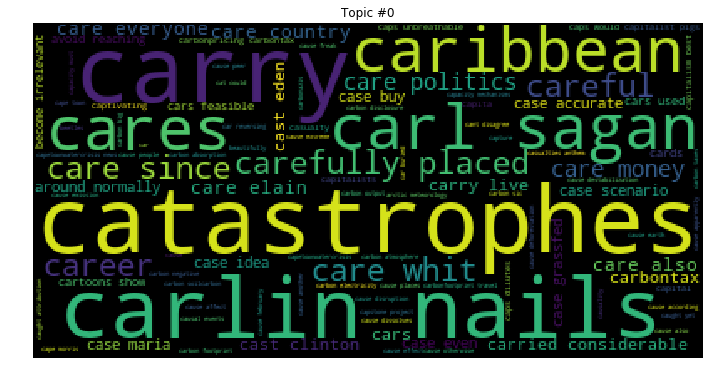

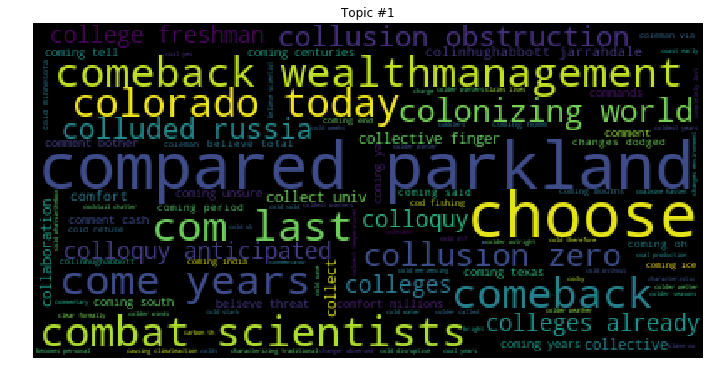

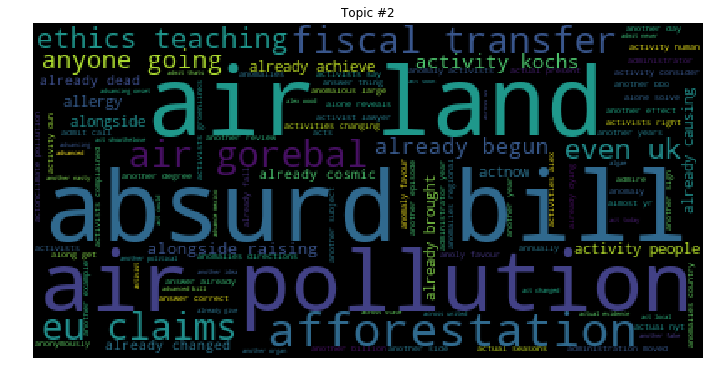

In [84]:
for t in range(num_topics):
    plt.figure(figsize = (12,16))
    plt.imshow(WordCloud().fit_words(dict(get_nmf_topics_freq(t, nmf_model,200))))
    plt.axis('off')
    plt.title('Topic #' + str(t))
    plt.show();

In [88]:
cleanDF[cleanDF.full_text.str.contains('carlin')]

,id,full_text
11570,NaN,george carlin nails it on global warming climate change the biggest con in modern human history maga potus


## Cluster